In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# Configurações
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = 'id_00'  # Substitua pelo caminho real do seu dataset


In [23]:
# Definição das classes do Transformer

class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, input_dim: int):
        super().__init__()
        self.d_model = d_model
        self.linear = nn.Linear(input_dim, d_model)
            
    def forward(self, x):
        # Projeto linear para d_model
        return self.linear(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) 
        pe[:, 1::2] = torch.cos(position * div_term) 
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe)
            
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return self.dropout(x)

class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(features, eps=eps)
            
    def forward(self, x):
        return self.layer_norm(x)

class ResidualConnection(nn.Module):
    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features)
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) 
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) 

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=h, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        attn_output, attn_weights = self.multihead_attn(query, key, value, key_padding_mask=mask)
        return self.dropout(attn_output)

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.feed_forward = FeedForwardBlock(d_model, d_ff, dropout)
        self.residual1 = ResidualConnection(d_model, dropout)
        self.residual2 = ResidualConnection(d_model, dropout)

    def forward(self, src, src_mask):
        src = self.residual1(src, lambda x: self.self_attn(x, x, x, mask=src_mask))
        src = self.residual2(src, self.feed_forward)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.cross_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.feed_forward = FeedForwardBlock(d_model, d_ff, dropout)
        self.residual1 = ResidualConnection(d_model, dropout)
        self.residual2 = ResidualConnection(d_model, dropout)
        self.residual3 = ResidualConnection(d_model, dropout)

    def forward(self, tgt, memory, src_mask, tgt_mask):
        tgt = self.residual1(tgt, lambda x: self.self_attn(x, x, x, mask=tgt_mask))
        tgt = self.residual2(tgt, lambda x: self.cross_attn(x, memory, memory, mask=src_mask))
        tgt = self.residual3(tgt, self.feed_forward)
        return tgt

class Encoder(nn.Module):
    def __init__(self, encoder_layer, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.norm = LayerNormalization(encoder_layer.self_attn.multihead_attn.embed_dim)

    def forward(self, src, src_mask):
        for layer in self.layers:
            src = layer(src, src_mask)
        return self.norm(src)

class Decoder(nn.Module):
    def __init__(self, decoder_layer, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])
        self.norm = LayerNormalization(decoder_layer.self_attn.multihead_attn.embed_dim)

    def forward(self, tgt, memory, src_mask, tgt_mask):
        for layer in self.layers:
            tgt = layer(tgt, memory, src_mask, tgt_mask)
        return self.norm(tgt)

class Transformer(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 d_model: int, 
                 num_layers: int, 
                 num_heads: int, 
                 d_ff: int, 
                 dropout: float, 
                 seq_len: int):
        super().__init__()
        self.encoder_embedding = InputEmbeddings(d_model, input_dim)
        self.encoder_pos = PositionalEncoding(d_model, seq_len, dropout)
        encoder_layer = EncoderLayer(d_model, num_heads, d_ff, dropout)
        self.encoder = Encoder(encoder_layer, num_layers)

        self.decoder_embedding = InputEmbeddings(d_model, input_dim)
        self.decoder_pos = PositionalEncoding(d_model, seq_len, dropout)
        decoder_layer = DecoderLayer(d_model, num_heads, d_ff, dropout)
        self.decoder = Decoder(decoder_layer, num_layers)

        self.output_layer = nn.Linear(d_model, input_dim)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = self.encoder_embedding(src)
        src = self.encoder_pos(src)
        memory = self.encoder(src, src_mask)

        tgt = self.decoder_embedding(tgt)
        tgt = self.decoder_pos(tgt)
        output = self.decoder(tgt, memory, src_mask, tgt_mask)

        output = self.output_layer(output)
        return output


In [24]:
class WavDataset(Dataset):
    def __init__(self, file_paths, labels=None, seq_len=128, n_mfcc=40, return_labels=False):
        """
        file_paths: lista de caminhos para os arquivos .wav
        labels: lista de labels (0 para normal, 1 para anormal). Necessário se return_labels=True
        seq_len: comprimento da sequência (número de frames)
        n_mfcc: número de coeficientes MFCC a serem extraídos
        return_labels: se True, retorna (dados, rótulos). Caso contrário, retorna (dados, dados)
        """
        self.file_paths = file_paths
        self.labels = labels
        self.seq_len = seq_len
        self.n_mfcc = n_mfcc
        self.return_labels = return_labels
        self.scaler = StandardScaler()

        # Pré-processar todos os dados e armazenar
        self.data = []
        for path in self.file_paths:
            mfcc = self.extract_mfcc(path)
            self.data.append(mfcc)
        
        # Converter para array numpy
        self.data = np.array(self.data)

        # Normalizar os dados
        # Reshape para aplicar o scaler em todas as amostras e características
        self.data = self.data.reshape(-1, self.n_mfcc)
        self.data = self.scaler.fit_transform(self.data)
        self.data = self.data.reshape(-1, self.seq_len, self.n_mfcc)
    
    def extract_mfcc(self, file_path):
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        # Pad ou truncar para seq_len
        if mfcc.shape[1] < self.seq_len:
            pad_width = self.seq_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0,0),(0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :self.seq_len]
        return mfcc.T  # (seq_len, n_mfcc)
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        if self.return_labels:
            label = self.labels[idx]
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor([label])
        else:
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor(self.data[idx])


In [25]:
# Função para listar arquivos .wav e seus labels
def get_file_paths_and_labels(data_path):
    normal_dir = os.path.join(data_path, 'normal')
    abnormal_dir = os.path.join(data_path, 'abnormal')
    
    normal_paths = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith('.wav')]
    abnormal_paths = [os.path.join(abnormal_dir, f) for f in os.listdir(abnormal_dir) if f.endswith('.wav')]
    
    normal_labels = [0]*len(normal_paths)
    abnormal_labels = [1]*len(abnormal_paths)
    
    return normal_paths, normal_labels, abnormal_paths, abnormal_labels

normal_paths, normal_labels, abnormal_paths, abnormal_labels = get_file_paths_and_labels(DATA_PATH)

# Dividir os dados
train_paths = normal_paths  # Treinar apenas com dados normais
train_labels = normal_labels  # Não será usado, mas mantido para consistência

test_paths = normal_paths + abnormal_paths  # Conjunto de teste com normal + anormal
test_labels = normal_labels + abnormal_labels

# Criar datasets
train_dataset = WavDataset(train_paths, labels=None, return_labels=False)
test_dataset = WavDataset(test_paths, labels=test_labels, return_labels=True)

# Criar dataloaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [26]:
# Parâmetros do Modelo
INPUT_DIM = 40  # Número de coeficientes MFCC
D_MODEL = 128
NUM_LAYERS = 4
NUM_HEADS = 8
D_FF = 512
DROPOUT = 0.1
SEQ_LEN = 128

# Inicializar o modelo
model = Transformer(input_dim=INPUT_DIM, 
                    d_model=D_MODEL, 
                    num_layers=NUM_LAYERS, 
                    num_heads=NUM_HEADS, 
                    d_ff=D_FF, 
                    dropout=DROPOUT, 
                    seq_len=SEQ_LEN).to(DEVICE)

# Função de perda e otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


AttributeError: 'MultiHeadAttentionBlock' object has no attribute 'multihead_attn'

In [20]:
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model(inputs, inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{EPOCHS}, Training Loss: {train_loss:.4f}')


Epoch 1/50, Training Loss: 1.1150
Epoch 2/50, Training Loss: 0.9033
Epoch 3/50, Training Loss: 0.7551
Epoch 4/50, Training Loss: 0.6541
Epoch 5/50, Training Loss: 0.5863
Epoch 6/50, Training Loss: 0.5371
Epoch 7/50, Training Loss: 0.5022
Epoch 8/50, Training Loss: 0.4731
Epoch 9/50, Training Loss: 0.4490
Epoch 10/50, Training Loss: 0.4302
Epoch 11/50, Training Loss: 0.4130
Epoch 12/50, Training Loss: 0.3978
Epoch 13/50, Training Loss: 0.3846
Epoch 14/50, Training Loss: 0.3726
Epoch 15/50, Training Loss: 0.3613
Epoch 16/50, Training Loss: 0.3503
Epoch 17/50, Training Loss: 0.3410
Epoch 18/50, Training Loss: 0.3307
Epoch 19/50, Training Loss: 0.3213
Epoch 20/50, Training Loss: 0.3131
Epoch 21/50, Training Loss: 0.3038
Epoch 22/50, Training Loss: 0.2953
Epoch 23/50, Training Loss: 0.2862
Epoch 24/50, Training Loss: 0.2782
Epoch 25/50, Training Loss: 0.2696
Epoch 26/50, Training Loss: 0.2614
Epoch 27/50, Training Loss: 0.2528
Epoch 28/50, Training Loss: 0.2446
Epoch 29/50, Training Loss: 0

AUC: 0.9600
Precision: 0.6000
Recall: 0.0600
F1-Score: 0.1091


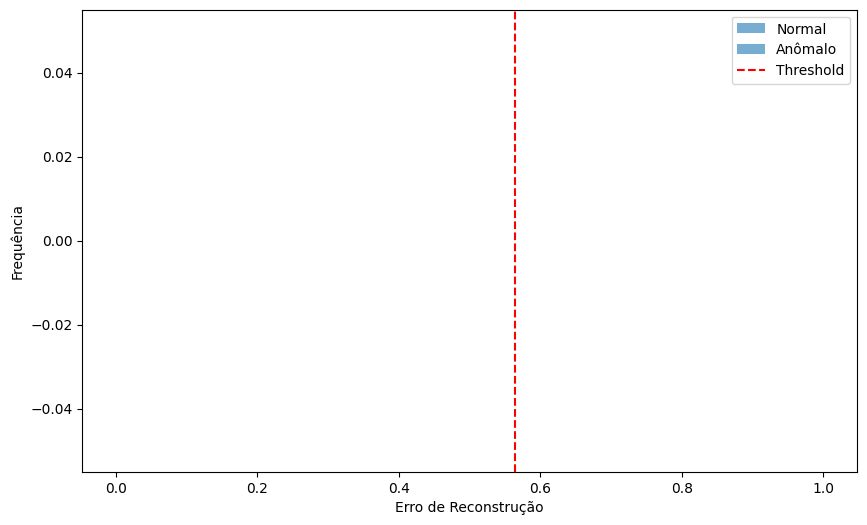

In [21]:
# Avaliação e Detecção de Anomalias

model.eval()
reconstruction_errors = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, batch_labels = batch  # Agora, batch_labels contém os rótulos reais
        inputs = inputs.to(DEVICE)
        # targets não são necessários para a avaliação
        outputs = model(inputs, inputs)
        # Calcular o erro de reconstrução por amostra
        loss = torch.mean((outputs - inputs)**2, dim=[1,2])  # Erro por amostra
        reconstruction_errors.extend(loss.cpu().numpy())
        labels.extend(batch_labels.numpy())  # Rótulos reais

# Normalizar os erros para [0,1]
errors = np.array(reconstruction_errors)
errors = (errors - errors.min()) / (errors.max() - errors.min())

# Definir um threshold para detecção
threshold = np.percentile(errors, 95)  # Por exemplo, 95º percentil

# Predições
preds = (errors > threshold).astype(int)

# Métricas
auc = roc_auc_score(labels, errors)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f'AUC: {auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Plotar a distribuição de erros
plt.figure(figsize=(10,6))
plt.hist(errors[labels==0], bins=50, alpha=0.6, label='Normal')
plt.hist(errors[labels==1], bins=50, alpha=0.6, label='Anômalo')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Erro de Reconstrução')
plt.ylabel('Frequência')
plt.legend()
plt.show()
